In [1]:
train_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Train' 
val_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Val' 
test_dir = 'D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Modelopropio/Database/Lung Segmentation Data/Lung Segmentation Data/Test'
articulo_dir='D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Implementacion/Deteccion_Articulo/dataset,solocovid,pneumonia'

In [2]:
#ELEGIMOS LOS PARAMETROS
from keras.preprocessing.image import ImageDataGenerator
ih, iw = 100,100 #tamano de la imagen
input_shape = (ih, iw, 3) #forma de la imagen: alto ancho y numero de canales

num_class = 2 #cuantas clases 
#epochs = 15 #cuantas veces entrenar. En cada epoch hace una mejora en los parametros

batch_size = 32 #batch para hacer cada entrenamiento. Lee 50 'batch_size' imagenes antes de actualizar los parametros. Las carga a memoria
num_train = 21715 #numero de imagenes en train
num_test = 6788 #numero de imagenes en test
num_val=5417

epoch_steps = num_train // batch_size 
test_steps = num_test // batch_size
 

Using TensorFlow backend.


In [3]:
#LEEMOS LAS IMÁGENES 

img_height, img_width=ih, iw

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as training data

validation_generator = train_datagen.flow_from_directory(
    val_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

test_generator = train_datagen.flow_from_directory(
    test_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

#Para el conjunto del artículo
articulo_generator = train_datagen.flow_from_directory(
    articulo_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data

Found 14507 images belonging to 2 classes.
Found 3615 images belonging to 2 classes.
Found 4535 images belonging to 2 classes.
Found 351 images belonging to 2 classes.


In [4]:
train=train_generator
val=validation_generator
test=test_generator
articulo=articulo_generator

In [6]:
from keras.applications import MobileNet
from keras.models import Model 
import keras 
import tensorflow as tf

mobilnet = tf.keras.applications.MobileNet(include_top=False, weights='imagenet',  
                                     input_shape=input_shape) 

mobilnet.trainable=True

In [ ]:
#for layer in Xception_model.layers[:-40]:
#    layer.trainable = False

In [7]:
import pandas as pd 
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in mobilnet.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

C:\Users\elium\.conda\envs\tfGPU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000014D7371D448>,input_2,True
1,<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x0000014D7371D2C8>,conv1_pad,True
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000014D04446408>,conv1,True
3,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000014D7371A308>,conv1_bn,True
4,<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x0000014D73862908>,conv1_relu,True
...,...,...,...
82,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000014D74099E88>,conv_dw_13_bn,True
83,<tensorflow.python.keras.layers.advanced_activations.ReLU object at 0x0000014D740A0E88>,conv_dw_13_relu,True
84,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000014D740A3788>,conv_pw_13,True
85,<tensorflow.python.keras.layers.normalization.BatchNormalization object at 0x0000014D740F5CC8>,conv_pw_13_bn,True


In [8]:
mobilnet.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 101, 101, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 50, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 50, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 50, 50, 32) 

In [9]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [10]:
from os import listdir
from os.path import isfile,isdir, join
import numpy

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import layers, models
from keras.models import Sequential
from keras.layers import Dense,Conv2D, Dropout,Activation,MaxPooling2D,Flatten
from keras.optimizers import RMSprop 
from sklearn.model_selection import train_test_split

In [11]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer 
from keras.models import Sequential 
from keras import optimizers 

# build model architecture 
model = tf.keras.Sequential()
model.add(mobilnet)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(num_class, activation='sigmoid'))
#compile model
model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.0001, momentum=0.9), 
      loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True), 
      metrics=['accuracy',f1_m,precision_m, recall_m])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Model)   (None, 3, 3, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1

In [22]:
history = model.fit_generator(train, steps_per_epoch=100, 
                              epochs=80,  
                              validation_data=val,   
                              validation_steps=50,  
                              verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/80
100/100 [==============================] - 5s 55ms/step - loss: 0.3450 - accuracy: 0.9747 - f1_m: 0.9734 - precision_m: 0.9741 - recall_m: 0.9728 - val_loss: 0.3679 - val_accuracy: 0.9419 - val_f1_m: 0.9416 - val_precision_m: 0.9421 - val_recall_m: 0.9413
Epoch 2/80
100/100 [==============================] - 5s 55ms/step - loss: 0.3433 - accuracy: 0.9770 - f1_m: 0.9767 - precision_m: 0.9766 - recall_m: 0.9769 - val_loss: 0.3688 - val_accuracy: 0.9419 - val_f1_m: 0.9431 - val_precision_m: 0.9438 - val_recall_m: 0.9425
Epoch 3/80
100/100 [==============================] - 6s 55ms/step - loss: 0.3437 - accuracy: 0.9770 - f1_m: 0.9768 - precision_m: 0.9785 - recall_m: 0.9753 - val_loss: 0.3671 - val_accuracy: 0.9438 - val_f1_m: 0.9445 - val_precision_m: 0.9429 - val_recall_m: 0.9463
Epoch 4/80
100/100 [==============================] - 5s 55ms/step - loss: 0.3475 - accuracy: 0.9719 - f1_

Epoch 31/80
100/100 [==============================] - 6s 55ms/step - loss: 0.3357 - accuracy: 0.9831 - f1_m: 0.9823 - precision_m: 0.9828 - recall_m: 0.9819 - val_loss: 0.3637 - val_accuracy: 0.9463 - val_f1_m: 0.9479 - val_precision_m: 0.9461 - val_recall_m: 0.9500
Epoch 32/80
100/100 [==============================] - 6s 56ms/step - loss: 0.3356 - accuracy: 0.9831 - f1_m: 0.9821 - precision_m: 0.9838 - recall_m: 0.9806 - val_loss: 0.3631 - val_accuracy: 0.9494 - val_f1_m: 0.9498 - val_precision_m: 0.9485 - val_recall_m: 0.9513
Epoch 33/80
100/100 [==============================] - 6s 55ms/step - loss: 0.3381 - accuracy: 0.9809 - f1_m: 0.9792 - precision_m: 0.9803 - recall_m: 0.9781 - val_loss: 0.3638 - val_accuracy: 0.9456 - val_f1_m: 0.9471 - val_precision_m: 0.9469 - val_recall_m: 0.9475
Epoch 34/80
100/100 [==============================] - 6s 55ms/step - loss: 0.3373 - accuracy: 0.9816 - f1_m: 0.9809 - precision_m: 0.9813 - recall_m: 0.9806 - val_loss: 0.3635 - val_accuracy: 0.9

Epoch 62/80
100/100 [==============================] - 6s 57ms/step - loss: 0.3329 - accuracy: 0.9853 - f1_m: 0.9848 - precision_m: 0.9856 - recall_m: 0.9841 - val_loss: 0.3618 - val_accuracy: 0.9494 - val_f1_m: 0.9476 - val_precision_m: 0.9465 - val_recall_m: 0.9488
Epoch 63/80
100/100 [==============================] - 6s 55ms/step - loss: 0.3340 - accuracy: 0.9830 - f1_m: 0.9825 - precision_m: 0.9829 - recall_m: 0.9822 - val_loss: 0.3617 - val_accuracy: 0.9494 - val_f1_m: 0.9478 - val_precision_m: 0.9475 - val_recall_m: 0.9481
Epoch 64/80
100/100 [==============================] - 6s 55ms/step - loss: 0.3297 - accuracy: 0.9884 - f1_m: 0.9880 - precision_m: 0.9878 - recall_m: 0.9881 - val_loss: 0.3625 - val_accuracy: 0.9488 - val_f1_m: 0.9495 - val_precision_m: 0.9484 - val_recall_m: 0.9506
Epoch 65/80
100/100 [==============================] - 5s 55ms/step - loss: 0.3294 - accuracy: 0.9880 - f1_m: 0.9872 - precision_m: 0.9872 - recall_m: 0.9872 - val_loss: 0.3616 - val_accuracy: 0.9

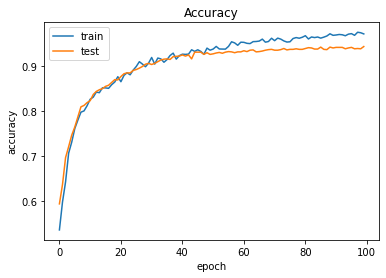

In [13]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

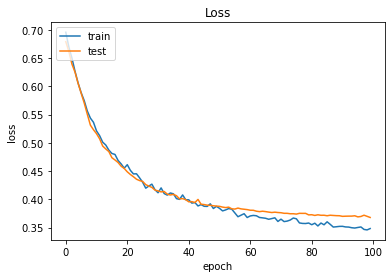

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

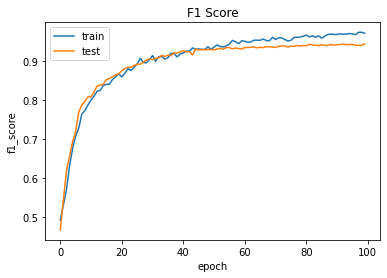

In [15]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('F1 Score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

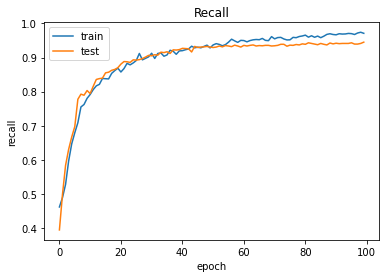

In [16]:
plt.plot(history.history['recall_m'])
plt.plot(history.history['val_recall_m'])
plt.title('Recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

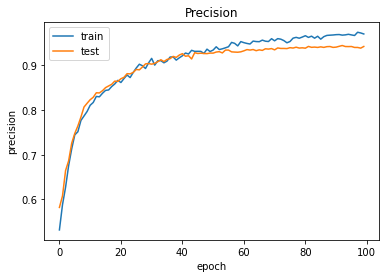

In [17]:
plt.plot(history.history['precision_m'])
plt.plot(history.history['val_precision_m'])
plt.title('Precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
test_eval = model.evaluate(test, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos de test para evaluar el modelo
  ...
    to  
  ['...']
142/142 [==============================] - 5s 36ms/step - loss: 0.3556 - accuracy: 0.9563 - f1_m: 0.9560 - precision_m: 0.9570 - recall_m: 0.9552
El modelo predice el  95.63395977020264 % de los datos


In [24]:
print('Utilizando el conjunto de datos de test para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos de test para evaluar el modelo
Loss:  0.3556034195591027
Accuracy:  0.9563396
F1 Score:  0.9560493
Precision:  0.95704836
Recall:  0.95520127


In [19]:
articulo_dir='D:/Documentos/Estudio/Maestría/Aprendizaje_Computacional/Implementacion/Deteccion_Articulo/dataset,solocovid,pneumonia'
#Para el conjunto del artículo
articulo_generator = train_datagen.flow_from_directory(
    articulo_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical') # set as validation data
articulo=articulo_generator

Found 351 images belonging to 2 classes.


In [25]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
test_eval = model.evaluate(articulo, verbose=1)
print('El modelo predice el ', test_eval[1]*100,'% de los datos')

Utilizando el conjunto de datos del artículo para evaluar el modelo
  ...
    to  
  ['...']
11/11 [==============================] - 4s 395ms/step - loss: 0.4748 - accuracy: 0.8348 - f1_m: 0.8312 - precision_m: 0.8276 - recall_m: 0.8350
El modelo predice el  83.47578644752502 % de los datos


In [26]:
print('Utilizando el conjunto de datos del artículo para evaluar el modelo')
print('Loss: ',test_eval[0])
print('Accuracy: ',test_eval[1])
print('F1 Score: ',test_eval[2])
print('Precision: ',test_eval[3])
print('Recall: ',test_eval[4])

Utilizando el conjunto de datos del artículo para evaluar el modelo
Loss:  0.47478841922499915
Accuracy:  0.83475786
F1 Score:  0.83118826
Precision:  0.8276096
Recall:  0.83495235


In [27]:
# Guardar el Modelo
model.save('modelMobilnetCovidysanos.h5')

In [28]:
print('180 eponchs')
pred=model.predict(articulo)
#Aquí sólo hago con  un predict con el modelo y los datos del artículo
import numpy as np
suma=0
for i in range (351):
    if np.argmax(pred[i])==0:
        suma=suma+1
print(suma)

180 eponchs
155
